In [ ]:
# Install required packages
!pip install transformers datasets torch seqeval



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00
 

In [ ]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizerFast, BertForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from seqeval.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
from sklearn.metrics import f1_score


In [ ]:
# Load dataset
dataset = load_dataset("conll2003")

print(f"Train set size: {len(dataset['train'])}")
print(f"Validation set size: {len(dataset['validation'])}")
print(f"Test set size: {len(dataset['test'])}")

print(dataset['train'][1])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Train set size: 14041
Validation set size: 3250
Test set size: 3453
{'id': '1', 'tokens': ['Peter', 'Blackburn'], 'pos_tags': [22, 22], 'chunk_tags': [11, 12], 'ner_tags': [1, 2]}


In [ ]:
tag_names = dataset['train'].features['ner_tags'].feature.names
print(f"\nTag names: {tag_names}")


Tag names: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


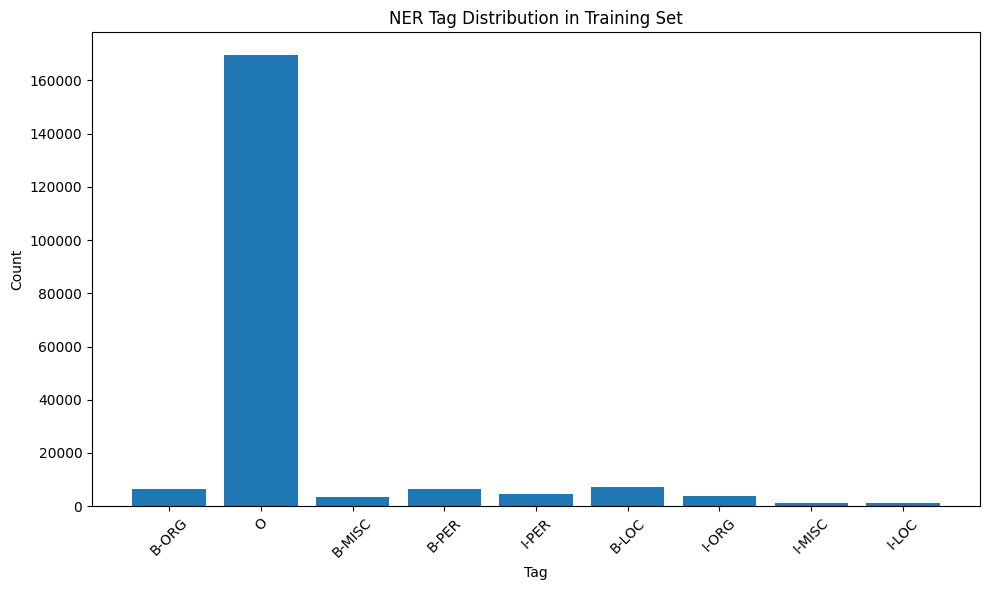

In [ ]:
# Count tag occurrences in the training set
tag_counts = {}
for example in dataset['train']:
    for tag in example['ner_tags']:
        tag_name = tag_names[tag]
        tag_counts[tag_name] = tag_counts.get(tag_name, 0) + 1

# Visualize tag distribution
plt.figure(figsize=(10, 6))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.title('NER Tag Distribution in Training Set')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

# Define label names
label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding="max_length", max_length=128, is_split_into_words=True)
    labels = []

    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        new_labels = []
        prev_word = None
        for word_id in word_ids:
            if word_id is None:
                new_labels.append(-100)  # Ignore padding
            elif word_id != prev_word:
                new_labels.append(label[word_id])
            else:
                new_labels.append(-100)  # Ignore subwords
            prev_word = word_id
        labels.append(new_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Tokenize dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Compute class weights (handle class imbalance)
label_counts = {i: 0 for i in range(num_labels)}
for labels in tokenized_datasets["train"]["ner_tags"]:
    for label in labels:
        if label != -100:
            label_counts[label] += 1

total_samples = sum(label_counts.values())
class_weights = torch.tensor([total_samples / (num_labels * label_counts[i]) if label_counts[i] > 0 else 0 for i in range(num_labels)], dtype=torch.float)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
# Custom model with weighted loss
class CustomBertForNER(BertForTokenClassification):
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = super().forward(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        return {"loss": loss, "logits": logits}

In [ ]:
# !pip install optuna
# import optuna
# from transformers import Trainer, TrainingArguments

# def objective(trial):

#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
#     batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
#     weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
#     epochs = trial.suggest_int("epochs", 3, 5)
#     # Data collator
#     data_collator = DataCollatorForTokenClassification(tokenizer)

# # Load model
#     model = CustomBertForNER.from_pretrained("bert-base-cased", num_labels=num_labels)

#     training_args = TrainingArguments(
#         output_dir="./results",
#         learning_rate=learning_rate,
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         num_train_epochs=epochs,
#         weight_decay=weight_decay,
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#         metric_for_best_model="loss",
#         greater_is_better=False
#     )

#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=tokenized_datasets["train"],
#         eval_dataset=tokenized_datasets["validation"],
#         tokenizer=tokenizer,
#         data_collator=data_collator
#     )

#     trainer.train()

#     # Evaluate model
#     eval_result = trainer.evaluate()
#     return eval_result["eval_loss"]  # Minimize loss

# # Run tuning
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)

# # Best hyperparameters
# print("Best Hyperparameters:", study.best_params)


[I 2025-03-11 18:56:53,314] A new study created in memory with name: no-name-0eb2322b-06a7-423f-a9c9-c19fb2bea0be
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-30-5867ab1e4558>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-cor

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sundarampandey11 (sundarampandey11-iit-roorkee) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.230500,0.195169
2,0.092700,0.219366
3,0.040600,0.210509


[I 2025-03-11 19:17:29,501] Trial 0 finished with value: 0.1951688826084137 and parameters: {'learning_rate': 4.267054562869743e-05, 'batch_size': 8, 'weight_decay': 0.031671214803764496, 'epochs': 3}. Best is trial 0 with value: 0.1951688826084137.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'cla

Epoch,Training Loss,Validation Loss
1,No log,0.177694
2,0.331100,0.173252
3,0.088200,0.167707
4,0.034400,0.181207


[I 2025-03-11 19:41:07,974] Trial 1 finished with value: 0.167706698179245 and parameters: {'learning_rate': 4.554532127223227e-05, 'batch_size': 32, 'weight_decay': 0.033509634428778794, 'epochs': 4}. Best is trial 1 with value: 0.167706698179245.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'clas

Epoch,Training Loss,Validation Loss
1,0.203400,0.185889
2,0.102400,0.224053
3,0.042100,0.226399
4,0.025400,0.251180
5,0.007500,0.252254


[I 2025-03-11 20:16:17,481] Trial 2 finished with value: 0.1858893483877182 and parameters: {'learning_rate': 3.210048799697024e-05, 'batch_size': 8, 'weight_decay': 0.042384440204810955, 'epochs': 5}. Best is trial 1 with value: 0.167706698179245.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'clas

Epoch,Training Loss,Validation Loss
1,0.438500,0.172470
2,0.099300,0.166067
3,0.040300,0.169743


[I 2025-03-11 20:34:59,377] Trial 3 finished with value: 0.16606733202934265 and parameters: {'learning_rate': 4.130024535171295e-05, 'batch_size': 16, 'weight_decay': 0.019861700697888885, 'epochs': 3}. Best is trial 3 with value: 0.16606733202934265.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', '

Epoch,Training Loss,Validation Loss
1,0.585700,0.193124
2,0.127500,0.167062
3,0.067400,0.186676
4,0.033100,0.190147


[I 2025-03-11 20:59:54,097] Trial 4 finished with value: 0.1670617163181305 and parameters: {'learning_rate': 1.6697667316536298e-05, 'batch_size': 16, 'weight_decay': 0.04661729255208498, 'epochs': 4}. Best is trial 3 with value: 0.16606733202934265.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'c

Epoch,Training Loss,Validation Loss
1,0.206500,0.185208
2,0.098900,0.234532
3,0.052800,0.205749
4,0.032300,0.226316
5,0.011100,0.232172


[I 2025-03-11 21:35:40,515] Trial 5 finished with value: 0.18520762026309967 and parameters: {'learning_rate': 2.392075431969042e-05, 'batch_size': 8, 'weight_decay': 0.02949677579065571, 'epochs': 5}. Best is trial 3 with value: 0.16606733202934265.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'cl

Epoch,Training Loss,Validation Loss
1,No log,0.193982
2,0.373600,0.162879
3,0.097000,0.162852
4,0.042900,0.176579


[I 2025-03-11 21:58:40,386] Trial 6 finished with value: 0.162851944565773 and parameters: {'learning_rate': 2.967227162032815e-05, 'batch_size': 32, 'weight_decay': 0.018625046400632637, 'epochs': 4}. Best is trial 6 with value: 0.162851944565773.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'clas

Epoch,Training Loss,Validation Loss
1,0.211500,0.196687
2,0.085200,0.205438
3,0.039900,0.199465


[I 2025-03-11 22:19:22,543] Trial 7 finished with value: 0.19668696820735931 and parameters: {'learning_rate': 2.739824761871564e-05, 'batch_size': 8, 'weight_decay': 0.07748561993056438, 'epochs': 3}. Best is trial 6 with value: 0.162851944565773.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'clas

Epoch,Training Loss,Validation Loss
1,No log,0.189527
2,0.421000,0.162999
3,0.106900,0.155338


[I 2025-03-11 22:37:16,974] Trial 8 finished with value: 0.15533798933029175 and parameters: {'learning_rate': 2.2281577413499185e-05, 'batch_size': 32, 'weight_decay': 0.027038599811883494, 'epochs': 3}. Best is trial 8 with value: 0.15533798933029175.
<ipython-input-30-5867ab1e4558>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
<ipython-input-30-5867ab1e4558>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.01, 0.1)
Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 

Epoch,Training Loss,Validation Loss
1,No log,0.194431
2,0.408800,0.161226
3,0.103400,0.163251
4,0.051100,0.161860


[I 2025-03-11 23:00:28,511] Trial 9 finished with value: 0.16122637689113617 and parameters: {'learning_rate': 2.384616990759959e-05, 'batch_size': 32, 'weight_decay': 0.03327912782470236, 'epochs': 4}. Best is trial 8 with value: 0.15533798933029175.


Best Hyperparameters: {'learning_rate': 2.2281577413499185e-05, 'batch_size': 32, 'weight_decay': 0.027038599811883494, 'epochs': 3}


In [ ]:
# Define best hyperparameters
best_lr = 2.2281577413499185e-05  # Found after initial tuning
best_batch_size = 32
best_epochs = 3

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=best_lr,
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=best_batch_size,
    num_train_epochs=best_epochs,
    weight_decay=0.027,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=True,
    push_to_hub=False
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# Load model
model = CustomBertForNER.from_pretrained("bert-base-cased", num_labels=num_labels)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train
trainer.train()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of CustomBertForNER were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-3bec94db6132>:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sundarampandey11 (sundarampandey11-iit-roorkee) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Evaluate
predictions = trainer.predict(tokenized_datasets["test"])

preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Align predictions with true labels (ignore -100)
true_labels, pred_labels = [], []
for label, pred in zip(labels, preds):
    for l, p in zip(label, pred):
        if l != -100:
            true_labels.append(l)
            pred_labels.append(p)

# Compute F1 Score
f1 = f1_score(true_labels, pred_labels, average="weighted")
print(f"Final F1 Score: {f1}")

Final F1 Score: 0.9797139500168397


In [ ]:
def predict_ner(sentence, model, tokenizer, label_list):
    model.eval()  # Set model to evaluation mode

    # Check if GPU is available and move model to GPU if possible
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model.to(device)  # Move the model to the GPU
    else:
        device = torch.device("cpu")

    # Tokenize input sentence into words
    words = sentence.split()  # Split sentence into words

    # Tokenize words
    tokenized_input = tokenizer(words,  # Pass the words list here
                                 truncation=True,
                                 padding="max_length",
                                 max_length=128,
                                 is_split_into_words=True,  # Important: Keep this as True
                                 return_tensors="pt")

    # Move input tensors to the same device as the model
    tokenized_input = tokenized_input.to(device)

    # Get word IDs to align labels properly
    word_ids = tokenized_input.word_ids()

    with torch.no_grad():
        outputs = model(input_ids=tokenized_input["input_ids"], attention_mask=tokenized_input["attention_mask"])
        logits = outputs["logits"]

    # Convert logits to predicted class indices
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()[0]

    # Convert indices to label names
    pred_tags = []
    prev_word_id = None
    for i, word_id in enumerate(word_ids):
        if word_id is None:  # Ignore padding tokens
            continue
        if word_id != prev_word_id:
            pred_tags.append(label_list[predictions[i]])  # Take only first subword's prediction
        prev_word_id = word_id

    # Print results properly aligned with tokens
    tokens = tokenizer.tokenize(sentence) # Tokenize sentence here, If you are want to show tokens
    print(f"\nSentence: {sentence}")
    print(f"Tokens: {tokens}")
    print(f"Predicted Tags: {pred_tags}")
    print("-" * 50)

# Example usage
sentence = "After graduating from Stanford University, Sundar Pichai joined Google in 2004 and later became the CEO of Alphabet Inc., headquartered in Mountain View, California."
predict_ner(sentence, model, tokenizer, label_list)



Sentence: After graduating from Stanford University, Sundar Pichai joined Google in 2004 and later became the CEO of Alphabet Inc., headquartered in Mountain View, California.
Tokens: ['After', 'graduating', 'from', 'Stanford', 'University', ',', 'Sun', '##dar', 'Pi', '##cha', '##i', 'joined', 'Google', 'in', '2004', 'and', 'later', 'became', 'the', 'CEO', 'of', 'Alpha', '##bet', 'Inc', '.', ',', 'headquartered', 'in', 'Mountain', 'View', ',', 'California', '.']
Predicted Tags: ['O', 'O', 'O', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'B-LOC', 'I-LOC', 'B-LOC']
--------------------------------------------------
